In [2]:
!pip3 install sklearn progress iterative-stratification pandas pyss3


In [3]:
from sys import path
import os

# Standard Stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, hamming_loss,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, multilabel_confusion_matrix, classification_report
# from util import binarize_to_list, binarize_to_matrix, predict_multilabel, eval_multilabel, load_multi_label, grid_search
import pyss3
from pyss3 import SS3, VERBOSITY
from pyss3.util import Dataset, Evaluation, span
from pyss3.server import Live_Test
from google.colab import drive

import numpy as np
import pandas as pd
import time
import itertools
import matplotlib.pyplot as plt


In [5]:
drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab'
path.append(path_root)
data_root = '/data/Muneeb'
# single_label_dir = '/SB1_Train-entity'

Mounted at /content/drive


In [6]:
from util import binarize_to_list, binarize_to_matrix, predict_multilabel, eval_multilabel, load_multi_label, grid_search
multi_label_dir_train = '/Movie-Train'
multi_label_dir_test = '/Movie-Test'

In [7]:
multi_text_train, multi_labels_train = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_train + '/summaries.txt',path_root + data_root + multi_label_dir_train + '/genres.txt', sep_label=';')
multi_text_test, multi_labels_test = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_test + '/summaries.txt',path_root + data_root + multi_label_dir_test + '/genres.txt', sep_label=';')

100%|██████████| 5680/5680 [00:00<00:00, 631541.68it/s]


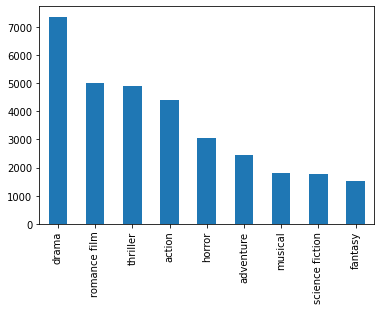

In [8]:
# CLASSES DISTRUBUTION

pd.Series([y for yy in multi_labels_train for y in yy]).value_counts().plot(kind ='bar')

In [9]:
def binarize_categories(cat, multi_labels_train):
  labels = []
  for i, x in enumerate(multi_labels_train):
    try:
      x.index(cat)
      if len(x) == 1:
        labels.append([cat])
      else:
        labels.append([cat, 'others'])
    except ValueError as e:
      labels.append(['others'])
  return labels

def predict(category_classifier,s_val,l_val,p_val,a_val, multi_text_test=multi_text_test):
    result = {}

    for key, value in category_classifier.items():
        value.set_hyperparameters(s=s_val,l=l_val,p=p_val)
        result[key]= value.predict(multi_text_test, def_cat='most-probable') 

    y_pred = [[] for _ in range(len(multi_text_test))]
    for i in range(len(multi_text_test)):
        temp = []
        for key, value in result.items():
            if value[i]:
                if value[i][0] != 'others':
                    temp.append(value[i][0])
            else:
                temp.append(key)
        y_pred[i] = list(set(temp))
    return y_pred


In [10]:
### one vs rest classifier training ###
pyss3.set_verbosity(1)

categories = list(set([y for yy in multi_labels_train for y in yy]))
category_classifier = {}
for cat in categories:
  modified_labels = binarize_categories(cat, multi_labels_train)
  clf = SS3(name=cat)
  clf.train(multi_text_train, modified_labels)
  category_classifier[cat] = clf

### default classifier training ###
clf = SS3()
clf.train(multi_text_train, multi_labels_train, n_grams=5)

Training: 100%|██████████| 16933/16933 [03:39<00:00, 77.17it/s]


In [18]:
s=[clf.get_s()]  # [0.2 , 0.32, 0.44, 0.56, 0.68, 0.8]
l=[clf.get_l()]   # [0.1 , 0.48, 0.86, 1.24, 1.62, 2]
p=[clf.get_p()]   # [1.75, 1.95, 2.15, 2.35, 2.55, 2.75]
a=[clf.get_a()]

In [19]:
pyss3.set_verbosity(0)
slpa = list(itertools.product(s,l,p,a))
iterations = len(slpa)
divider = 1
current_iteration = 0
last_metric_value = 0
last_metric_value_default = 0
best_binarized_predicted = []
best_binarized_predicted_default = []
binarized_true = binarize_to_matrix(multi_labels_test, categories)


for s,l,p,a in iter(slpa):
    current_iteration += 1
    print('\r',current_iteration, end='')

    y_pred = predict(category_classifier,s,l,p,a)
    binarized_predicted = binarize_to_matrix(y_pred, categories)
    metric_value= eval_multilabel(binarized_true, binarized_predicted, f1_score, **{"average":"macro", "zero_division" : 0})
    ##save and print##
    if(metric_value > last_metric_value):
        best_binarized_predicted = binarized_predicted
        last_metric_value = metric_value
        best = (s,l,p,a)

    clf.set_hyperparameters(s,l,p,a)
    y_pred_default = clf.predict(multi_text_test)
    binarized_predicted_default = binarize_to_matrix(y_pred_default, categories)
    metric_value_default= eval_multilabel(binarized_true, binarized_predicted_default, f1_score, **{"average":"macro", "zero_division" : 0})
    if(metric_value_default > last_metric_value_default):
        best_binarized_predicted_default = binarized_predicted_default
        last_metric_value_default = metric_value_default
        best_default = (s,l,p,a)


    if(current_iteration%divider == 0):
        print(' -> best value so far: ', last_metric_value, ' -> best values: s={}, l={}, p={}, a={}'.format(best[0], best[1], best[2], best[3]), "iterations: ", current_iteration, "/", iterations)
        print(' -> best value so far: ', last_metric_value_default, ' -> best values: s={}, l={}, p={}, a={}'.format(best_default[0], best_default[1], best_default[2], best_default[3]), "iterations: ", current_iteration, "/", iterations)
        print('------------')

 1 -> best value so far:  0.5358291919235681  -> best values: s=0.45, l=0.5, p=1.0, a=0.0 iterations:  1 / 1
 -> best value so far:  0.4972720706945252  -> best values: s=0.45, l=0.5, p=1.0, a=0.0 iterations:  1 / 1
------------


**#### One vs Rest Results #####**

0.5358291919235681
                 precision    recall  f1-score   support

         action       0.43      0.78      0.56      1467
        fantasy       0.37      0.50      0.42       503
       thriller       0.37      0.94      0.53      1632
science fiction       0.58      0.54      0.56       584
      adventure       0.45      0.53      0.49       812
          drama       0.44      1.00      0.61      2454
   romance film       0.43      0.95      0.60      1666
        musical       0.24      0.87      0.38       603
         horror       0.62      0.78      0.69      1020

      micro avg       0.41      0.84      0.56     10741
      macro avg       0.44      0.76      0.54     10741
   weighted avg       0.44      0.84      0.56     10741
    samples avg       0.44      0.85      0.55     10741



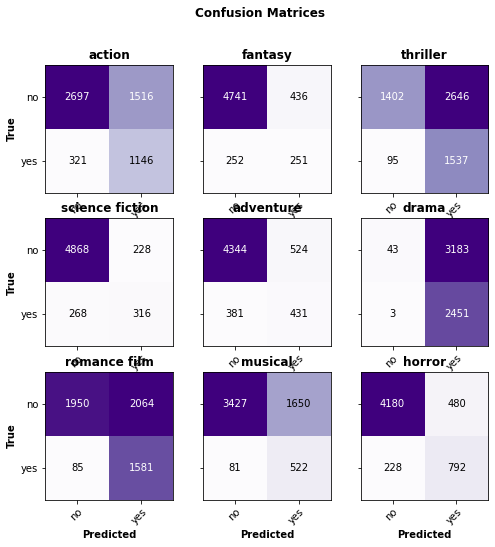

In [20]:


print(f1_score(binarized_true, best_binarized_predicted, average = "macro",zero_division = 0))

cms = multilabel_confusion_matrix(binarized_true, best_binarized_predicted)
print(classification_report(binarized_true, best_binarized_predicted,target_names=categories, zero_division=1))
Evaluation.__plot_confusion_matrices__(cms, categories, multilabel = True)

**DEFAULT MULTI-LABEL Result**


                 precision    recall  f1-score   support

       thriller       0.65      0.43      0.52      1632
          drama       0.54      0.63      0.58      2454
         horror       0.68      0.57      0.62      1020
   romance film       0.34      0.96      0.50      1666
         action       0.68      0.32      0.43      1467
      adventure       0.53      0.36      0.43       812
        fantasy       0.32      0.47      0.38       503
        musical       0.29      0.72      0.41       603
science fiction       0.58      0.63      0.60       584

      micro avg       0.46      0.58      0.51     10741
      macro avg       0.51      0.56      0.50     10741
   weighted avg       0.53      0.58      0.51     10741
    samples avg       0.49      0.60      0.50     10741


 Exact Match Ratio: 0.119
 Hamming Loss: 0.233
[ updating evaluations cache ]


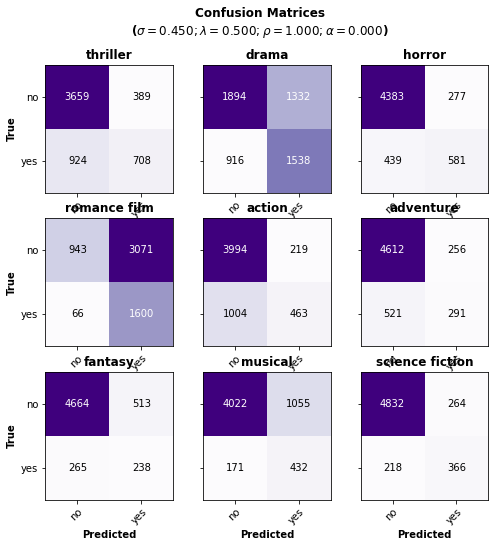

0.23278560250391236

In [21]:
clf.set_hyperparameters(s=best_default[0], l=best_default[1], p=best_default[2], a=best_default[3])
Evaluation.test(clf, multi_text_test, multi_labels_test)